In [1]:
pip install mysql-connector-python 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',  # or IP address, e.g., '127.0.0.1' or remote host
    user='root',
    password='Sundram@1234.',
    database='ecommerce'
)

cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Asus/Desktop/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db=mysql.connector.connect(
    host='localhost',  # or IP address, e.g., '127.0.0.1' or remote host
    user='root',
    password='Sundram@1234.',
    database='ecommerce'
)
cur=db.cursor()

# List all unique cities where customers are located.

In [4]:
query="""select distinct customer_city from customers"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [5]:
query="""select count(order_id) from ecommerce.orders where year(order_purchase_timestamp)='2017'"""
cur.execute(query)
data=cur.fetchall()
print("total orders placed in 2017 are",data[0][0])

total orders placed in 2017 are 135303


# Find the total sales per category.

In [6]:
query="""select products.product_category as category, 
round(sum(payments.payment_value),2) as sales from ecommerce.products 
join ecommerce.order_items
on order_items.product_id=products.product_id 
join ecommerce.payments
on payments.order_id=order_items.order_id
group by product_category"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["Category","Sales"])
df

,Category,Sales
0,perfumery,13681943.82
1,Furniture Decoration,38614762.58
2,telephony,13145815.37
3,bed table bath,46238949.12
4,automotive,23011946.94
...,...,...
69,cds music dvds,32384.61
70,La Cuisine,78665.31
71,Fashion Children's Clothing,21213.09
72,PC Gamer,58709.61


# Calculate the percentage of orders that were paid in installments.

In [7]:
query="""select (sum(case when payment_installments>=1 then 1 
else 0 end )/count(*)*100) from ecommerce.payments """
cur.execute(query)
data=cur.fetchall()
print("The percentage of orders that were paid in installments is",data[0][0])

The percentage of orders that were paid in installments is 99.9981


# Count the number of customers from each state

   State  No of customers
0     SP           125238
1     SC            10911
2     MG            34905
3     PR            15135
4     RJ            38556
5     RS            16398
6     PA             2925
7     GO             6060
8     ES             6099
9     BA            10140
10    MA             2241
11    MS             2145
12    CE             4008
13    DF             6420
14    RN             1455
15    PE             4956
16    MT             2721
17    AM              444
18    AP              204
19    AL             1239
20    RO              759
21    PB             1608
22    TO              840
23    PI             1485
24    AC              243
25    SE             1050
26    RR              138


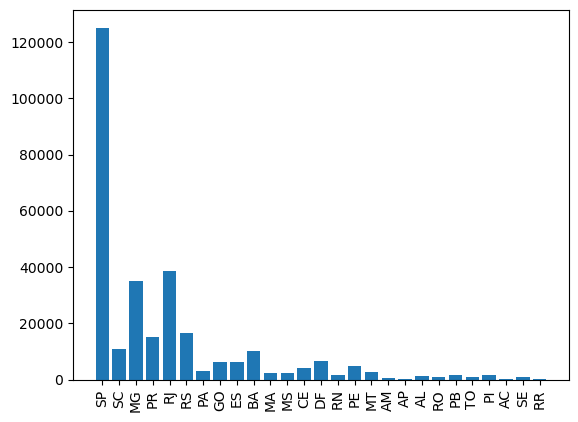

In [8]:
query="""select customer_state,count(customer_id) from ecommerce.customers group by 
customer_state"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["State","No of customers"])
print(df)
plt.bar(df["State"],df["No of customers"])
plt.xticks(rotation='vertical')
plt.show()

# Calculate the number of orders per month in 2018.

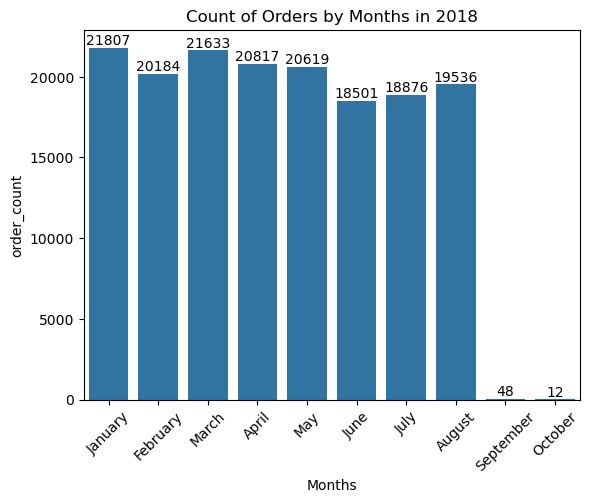

In [9]:
query="""select monthname(order_purchase_timestamp) as Months
,count(order_id) from ecommerce.orders where 
year(order_purchase_timestamp)=2018
group by months; """
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["Months","order_count"])
o=["January","February","March","April","May","June","July","August","September","October"]
ax=sns.barplot(x=df["Months"],y=df["order_count"],data=df,order=o)
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months in 2018")
plt.show()                            

# Find the average number of products per order, grouped by customer city.

In [10]:

query="""select c.customer_city, round(avg(order_product_count),2) as opc
from (
		select o.order_id,o.customer_id, count(oc.order_id) as order_product_count 
        from ecommerce.orders o join ecommerce.order_items oc on o.order_id=oc.order_id
        group by o.order_id,o.customer_id
		
) as sub join ecommerce.customers c on sub.customer_id= c. customer_id
group by c.customer_city order by opc desc"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["Customer_City","Average number of Products per Order"])
df.head()

,Customer_City,Average number of Products per Order
0,padre carvalho,63.00
1,celso ramos,58.50
2,datas,54.00
3,candido godoi,54.00
4,matias olimpio,45.00


# Calculate the percentage of total revenue contributed by each product category.

In [11]:
 query="""select products.product_category as category, 
round((sum(payments.payment_value)/(select sum(payment_value) from ecommerce.payments))*100,2) as sales_percentage from ecommerce.products 
join ecommerce.order_items
on order_items.product_id=products.product_id 
join ecommerce.payments
on payments.order_id=order_items.order_id
group by product_category order by sales_percentage desc;"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["Category","Sales"])
df.head()

,Category,Sales
0,bed table bath,96.28
1,HEALTH BEAUTY,93.18
2,computer accessories,89.13
3,Furniture Decoration,80.40
4,Watches present,80.35


# Identify the correlation between product price and the number of times a product has been purchased.

# Calculate the total revenue generated by each seller, and rank them by revenue.

In [12]:
query="""select * ,
		dense_rank() over (order by total_revenue desc) from (select oi.seller_id, sum(pay.payment_value) as total_revenue from ecommerce.order_items oi join 
ecommerce.payments pay on oi.order_id=pay.order_id
group by seller_id) as a;"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["Seller ID","Toatl Revenue","Rank"])
df.head()

,Seller ID,Toatl Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,4.564502e+06,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,2.773998e+06,2
2,4a3ca9315b744ce9f8e9374361493884,2.711207e+06,3
3,1f50f920176fa81dab994f9023523100,2.612281e+06,4
4,53243585a1d6dc2643021fd1853d8905,2.564128e+06,5


# Calculate the moving average of order values for each customer over their order history.

In [13]:
#A moving average calculates the mean of a subset of data points within a defined window.
query="""select customer_id, order_purchase_timestamp, payment,avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg from 
(select o.customer_id, o.order_purchase_timestamp, p.payment_value as payment
from ecommerce.orders o join ecommerce.payments p on o.order_id=p.order_id) as a;"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["Customer ID","Time Stamp","Price","Moving Average"])
df

,Customer ID,Time Stamp,Price,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
934969,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934970,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934971,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934972,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

In [21]:
query="""select years,months,payment,sum(payment) over(order by years,months) as cumulative_sales from
(select year(o.order_purchase_timestamp) as years,
month(o.order_purchase_timestamp) as months,
round(sum(p.payment_value),2) as payment from ecommerce.orders as o join ecommerce.payments as p
on o.order_id=p.order_id group by months,years order by months,years) as a;"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["Year","Month","Payment","Cumulative Sales"])
df.head(10)

,Year,Month,Payment,Cumulative Sales
0,2016,9,2270.16,2270.16
1,2016,10,531814.32,534084.48
2,2016,12,176.58,534261.06
3,2017,1,1246392.36,1780653.42
4,2017,2,2627172.09,4407825.51
5,2017,3,4048772.40,8456597.91
6,2017,4,3760092.27,12216690.18
7,2017,5,5336269.38,17552959.56
8,2017,6,4601487.42,22154446.98
9,2017,7,5331446.28,27485893.26


# Calculate the year-over-year growth rate of total sales.

In [25]:
query="""select years,
(payment-lag(payment,1) over (order by years)/lag(payment,1) over (order by years)*100) as yoy from 
(select year(o.order_purchase_timestamp) as years,
round(sum(p.payment_value),2) as payment from ecommerce.orders as o join ecommerce.payments as p
on o.order_id=p.order_id group by years order by years)as a;"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["Year","YOY%growth"])
df.head()

,Year,YOY%growth
0,2016,NaN
1,2017,65247620.55
2,2018,78297767.47


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [26]:
query="""with a as (select c.customer_id, min(o.order_purchase_timestamp) first_order
from ecommerce.customers c join ecommerce.orders o on c.customer_id=o.customer_id group by c.customer_id),

b as (select a.customer_id, count(distinct o.order_purchase_timestamp) from a join ecommerce.orders o on a.customer_id=o.customer_id
and o.order_purchase_timestamp> first_order
and o.order_purchase_timestamp < date_add(first_order,interval 6 month)
group by customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id)) from a left join b 
on a.customer_id=b.customer_id;"""
cur.execute(query)
data=cur.fetchall()
data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

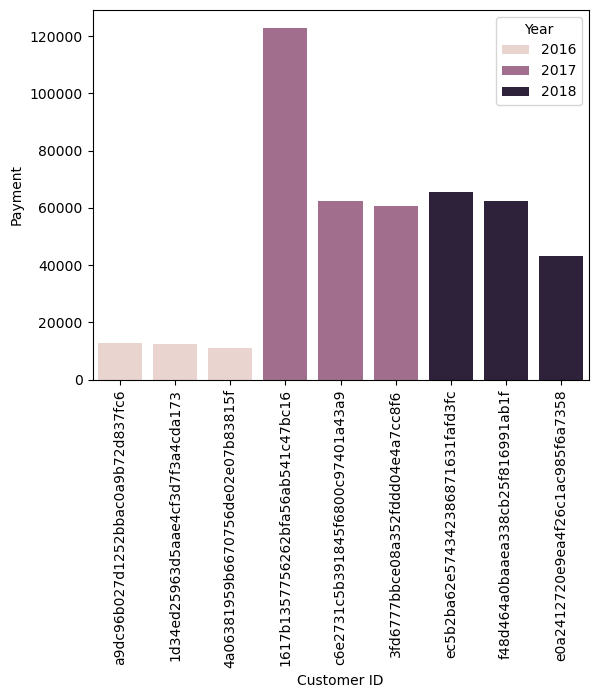

In [32]:
query="""SELECT years, customer_id, payment, drank
FROM (
SELECT o.customer_id, YEAR(order_purchase_timestamp) AS years, SUM(p.payment_value) AS payment,
DENSE_RANK() OVER ( PARTITION BY YEAR(o.order_purchase_timestamp)
            ORDER BY SUM(p.payment_value) DESC) AS drank
FROM ecommerce.orders o JOIN ecommerce.payments p ON o.order_id = p.order_id 
GROUP BY o.customer_id, YEAR(order_purchase_timestamp)) AS a WHERE drank <= 3;"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["Year","Customer ID","Payment","Rank"])
df
sns.barplot(x="Customer ID",y="Payment" ,data=df,hue="Year")
plt.xticks(rotation=90)
plt.show()